In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(600, 800)

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(theta, y, noise_var, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = sbl_algorithm(theta, received_signal, noise_power)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Samples:   2%|▏         | 4/200 [08:23<6:51:11, 125.87s/it]

Converged after 447 iterations



Processing Samples:   6%|▋         | 13/200 [26:58<6:28:08, 124.54s/it]

Converged after 399 iterations



Processing Samples:   8%|▊         | 16/200 [33:18<6:25:51, 125.82s/it]

Converged after 469 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:20, 20.01s/it]

Converged after 463 iterations



Processing Samples:   8%|▊         | 17/200 [35:19<6:19:50, 124.54s/it]

Converged after 406 iterations



Processing Samples:  10%|█         | 20/200 [41:35<6:14:40, 124.89s/it]

Converged after 492 iterations



Processing Samples:  11%|█         | 22/200 [45:49<6:13:08, 125.78s/it]

Converged after 473 iterations



Processing Samples:  16%|█▌        | 31/200 [1:04:55<5:59:21, 127.58s/it]

Converged after 493 iterations



Processing Samples:  16%|█▌        | 32/200 [1:06:59<5:54:24, 126.58s/it]

Converged after 455 iterations



Processing Samples:  20%|██        | 40/200 [1:23:48<5:35:58, 125.99s/it]

Converged after 412 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.70s/it]

Converged after 477 iterations



Processing Samples:  22%|██▎       | 45/200 [1:34:13<5:22:23, 124.80s/it]

Converged after 437 iterations



Processing Samples:  26%|██▌       | 52/200 [1:48:51<5:08:32, 125.09s/it]

Converged after 463 iterations



Processing Samples:  28%|██▊       | 56/200 [1:57:10<4:58:01, 124.18s/it]

Converged after 462 iterations



Processing Samples:  30%|███       | 60/200 [2:05:26<4:49:28, 124.06s/it]

Converged after 492 iterations



Processing Samples:  32%|███▎      | 65/200 [2:15:44<4:36:59, 123.11s/it]

Converged after 470 iterations



Processing Samples:  33%|███▎      | 66/200 [2:17:44<4:33:19, 122.38s/it]

Converged after 463 iterations



Processing Samples:  36%|███▌      | 71/200 [2:27:53<4:21:08, 121.46s/it]

Converged after 405 iterations



Processing Samples:  38%|███▊      | 75/200 [2:36:02<4:14:23, 122.11s/it]

Converged after 496 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.86s/it]

Converged after 481 iterations



Processing Samples:  40%|████      | 80/200 [2:46:21<4:06:34, 123.29s/it]

Converged after 466 iterations



Processing Samples:  42%|████▏     | 83/200 [2:52:46<4:08:01, 127.19s/it]

Converged after 497 iterations



Processing Samples:  45%|████▌     | 90/200 [3:07:09<3:45:05, 122.78s/it]

Converged after 465 iterations



Processing Samples:  46%|████▋     | 93/200 [3:13:21<3:40:24, 123.59s/it]

Converged after 500 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.81s/it]

Converged after 474 iterations



Processing Samples:  54%|█████▎    | 107/200 [3:42:05<3:11:11, 123.35s/it]

Converged after 487 iterations



Processing Samples:  54%|█████▍    | 108/200 [3:44:08<3:09:02, 123.29s/it]

Converged after 491 iterations



Processing Samples:  55%|█████▍    | 109/200 [3:46:12<3:07:31, 123.64s/it]

Converged after 485 iterations



Processing Samples:  56%|█████▌    | 111/200 [3:50:30<3:06:32, 125.76s/it]

Converged after 482 iterations



Processing Samples:  56%|█████▌    | 112/200 [3:52:33<3:03:26, 125.08s/it]

Converged after 495 iterations



Processing Samples:  58%|█████▊    | 117/200 [4:02:56<2:51:23, 123.89s/it]

Converged after 439 iterations



Processing Samples:  59%|█████▉    | 118/200 [4:04:56<2:47:39, 122.68s/it]

Converged after 422 iterations



Processing Samples:  60%|█████▉    | 119/200 [4:06:52<2:43:05, 120.80s/it]

Converged after 439 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.94s/it]

Converged after 456 iterations



Processing Samples:  62%|██████▏   | 123/200 [4:14:47<2:32:41, 118.98s/it]

Converged after 472 iterations



Processing Samples:  70%|██████▉   | 139/200 [4:46:56<2:01:48, 119.81s/it]

Converged after 467 iterations



Processing Samples:  72%|███████▏  | 143/200 [4:54:57<1:54:10, 120.19s/it]

Converged after 461 iterations



Processing Samples:  72%|███████▎  | 145/200 [4:59:02<1:51:06, 121.20s/it]

Converged after 476 iterations



Processing Samples:  74%|███████▍  | 148/200 [5:04:58<1:43:24, 119.31s/it]

Converged after 418 iterations



Processing Samples:  75%|███████▌  | 150/200 [5:08:51<1:38:07, 117.74s/it]

Converged after 451 iterations



Processing Samples:  76%|███████▋  | 153/200 [5:14:49<1:32:59, 118.71s/it]

Converged after 434 iterations



Processing Samples:  80%|████████  | 160/200 [5:28:35<1:18:04, 117.10s/it]

Converged after 434 iterations



Processing Samples:  80%|████████  | 161/200 [5:30:33<1:16:16, 117.35s/it]

Converged after 425 iterations



Processing Samples:  82%|████████▏ | 164/200 [5:36:29<1:10:43, 117.87s/it]

Converged after 471 iterations



Processing Samples:  84%|████████▎ | 167/200 [5:42:21<1:04:39, 117.57s/it]

Converged after 480 iterations



Processing Samples:  86%|████████▌ | 171/200 [5:50:08<56:28, 116.83s/it]

Converged after 447 iterations



Processing Samples:  87%|████████▋ | 174/200 [5:56:00<50:48, 117.25s/it]

Converged after 491 iterations



Processing Samples:  88%|████████▊ | 175/200 [5:57:58<48:56, 117.47s/it]

Converged after 421 iterations



Processing Samples:  88%|████████▊ | 176/200 [5:59:55<46:51, 117.16s/it]

Converged after 458 iterations



Processing Samples:  92%|█████████▎| 185/200 [6:17:32<29:22, 117.52s/it]

Converged after 426 iterations



Processing Samples:  96%|█████████▋| 193/200 [6:33:57<14:14, 122.03s/it]

Converged after 467 iterations



Processing Samples:  98%|█████████▊| 197/200 [6:42:18<06:12, 124.24s/it]

Converged after 442 iterations



Processing Samples: 100%|██████████| 200/200 [6:48:21<00:00, 122.51s/it]

Converged after 469 iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [ 9.25  13.625 18.36  19.625 19.845 19.905]
Avg SRR : [0.04152697 0.07150716 0.12700905 0.15942736 0.17331337 0.18342406]
Avg FR  : [0.81552632 0.71894737 0.42526316 0.23947368 0.15315789 0.09      ]
Avg PR  : [0.0755906  0.101288   0.14037662 0.16356076 0.17545678 0.18496875]
Avg RE  : [0.0925  0.13625 0.1836  0.19625 0.19845 0.19905]
Avg F1  : [0.08297978 0.11593553 0.15875359 0.17811461 0.18596963 0.191542  ]
Avg NMSE: [0.14267259 0.09723328 0.0417856  0.02172712 0.01463075 0.01136666]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-sbl-snr-db-12-pilot-length-all-set-4.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


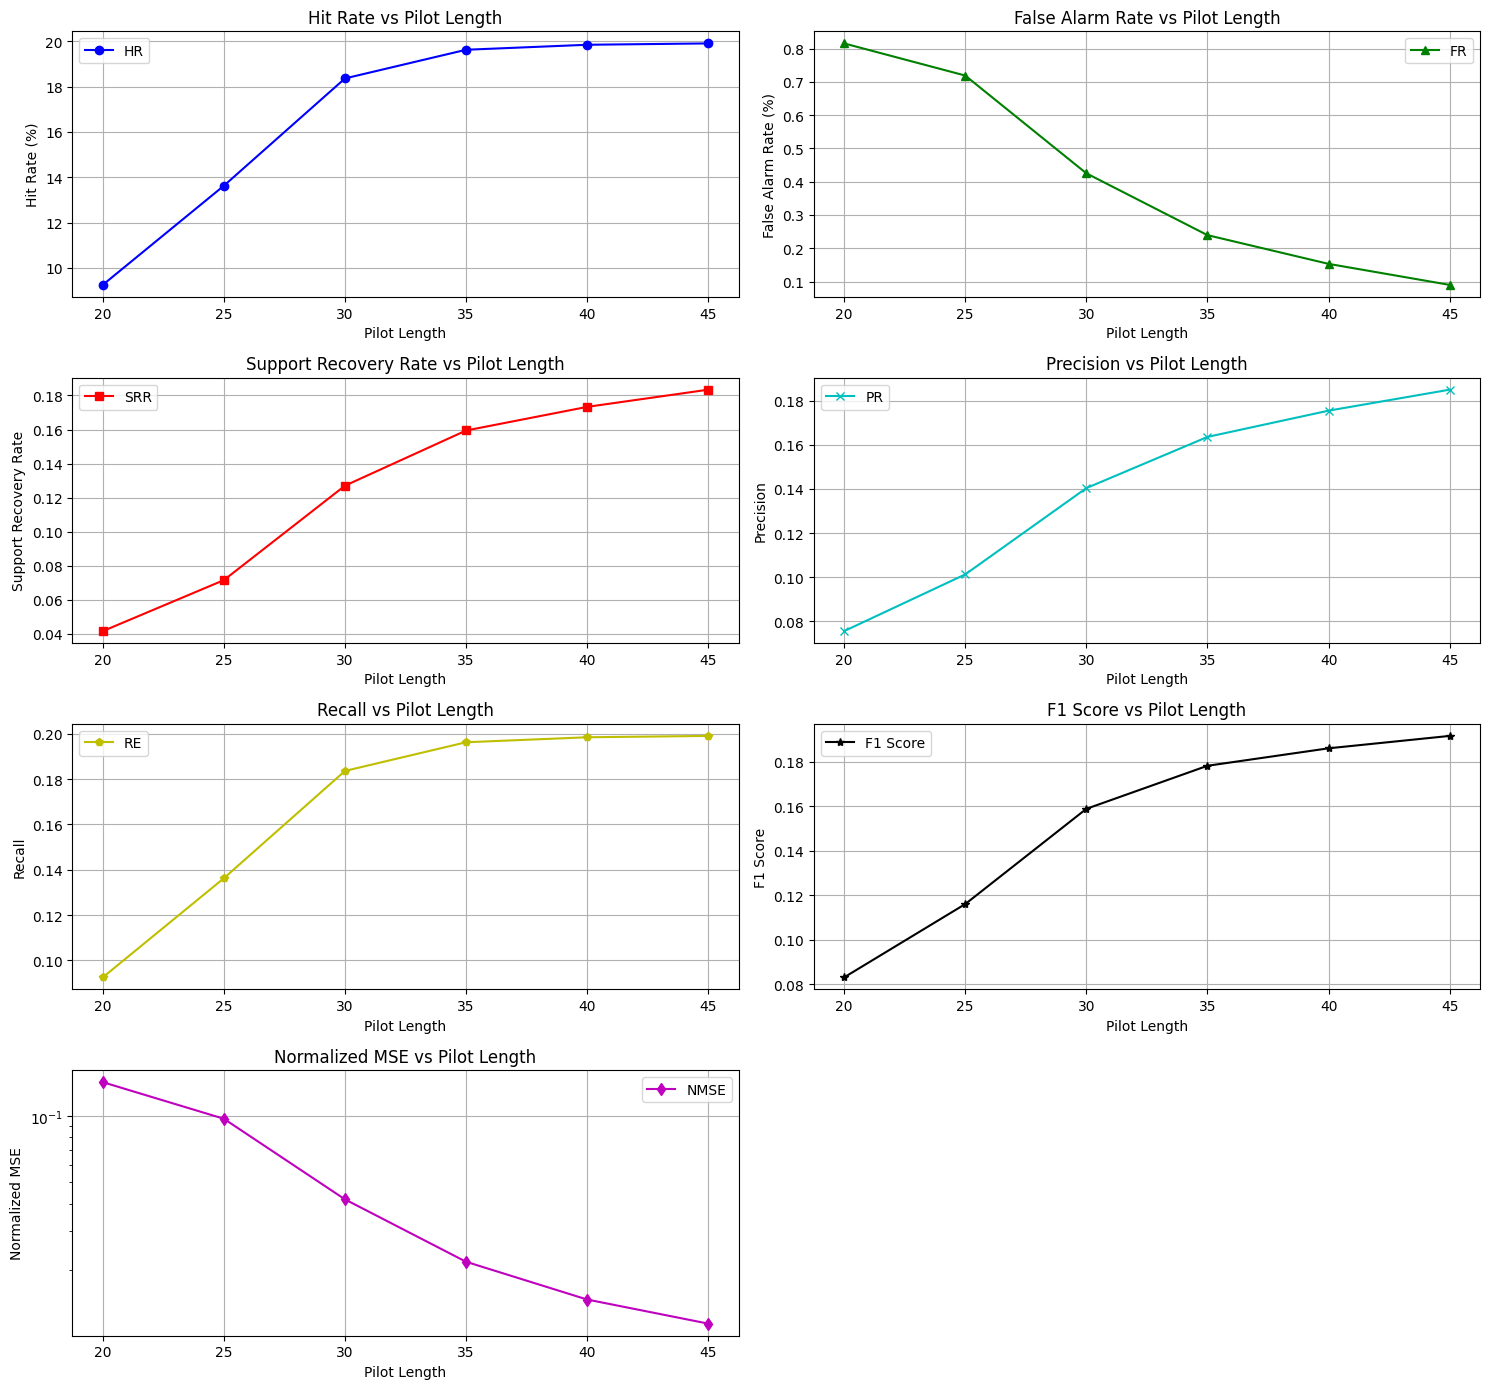

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

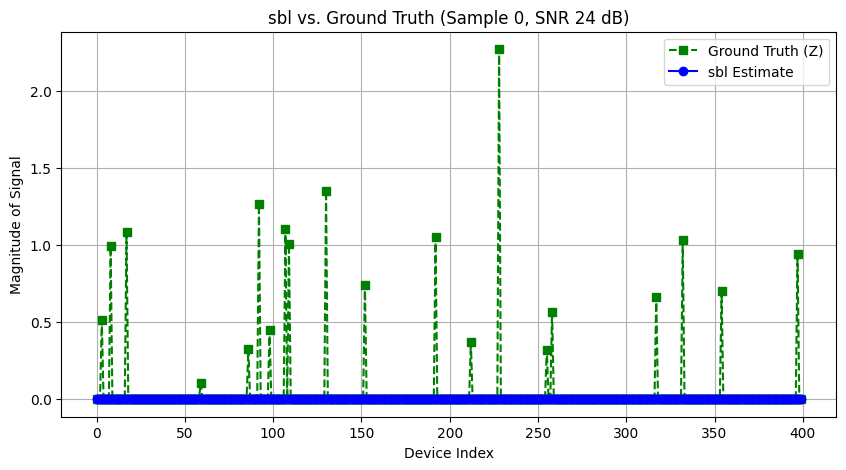

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


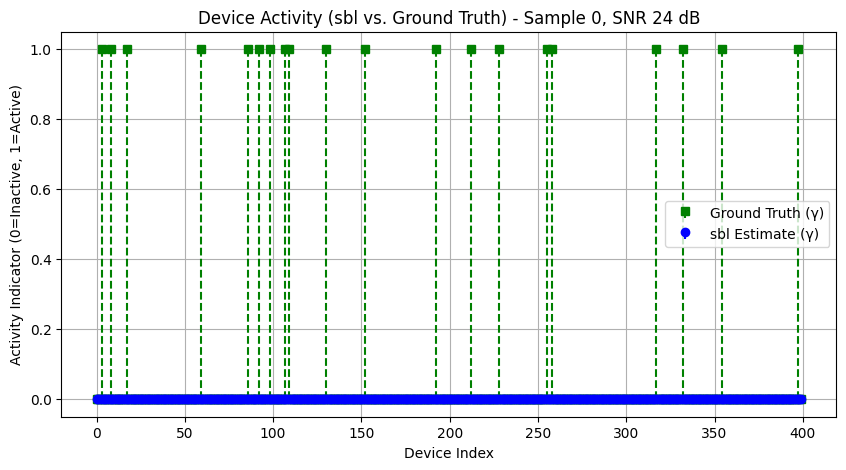

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)